In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn import cluster

np.random.seed(0)

## Datasets

In [2]:
# Inspired by: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

datasets = [
    noisy_circles,
    noisy_moons,
    varied, 
    aniso,
    blobs,
    no_structure,
]

## Algorithm

In [3]:
# Inspired by: https://github.com/eriklindernoren/ML-From-Scratch/blob/a2806c6732eee8d27762edd6d864e0c179d8e9e8/mlfromscratch/unsupervised_learning/dbscan.py
from __future__ import print_function, division
import numpy as np
import math

def euclidean_distance(x1, x2):
    """ Calculates the l2 distance between two vectors """
    distance = 0
    # Squared distance between each coordinate
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return math.sqrt(distance)

class DBSCAN():
    """A density based clustering method that expands clusters from 
    samples that have more neighbors within a radius specified by eps
    than the value min_samples.
    Parameters:
    -----------
    eps: float
        The radius within which samples are considered neighbors
    min_samples: int
        The number of neighbors required for the sample to be a core point. 
    """
    def __init__(self, eps=1, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def _get_neighbors(self, sample_i):
        """ Return a list of indexes of neighboring samples
        A sample_2 is considered a neighbor of sample_1 if the distance between
        them is smaller than epsilon """
        neighbors = []
        idxs = np.arange(len(self.X))
        for i, _sample in enumerate(self.X[idxs != sample_i]):
            distance = euclidean_distance(self.X[sample_i], _sample)
            if distance < self.eps:
                neighbors.append(i)
        return np.array(neighbors)

    def _expand_cluster(self, sample_i, neighbors):
        """ Recursive method which expands the cluster until we have reached the border
        of the dense area (density determined by eps and min_samples) """
        cluster = [sample_i]
        # Iterate through neighbors
        for neighbor_i in neighbors:
            if not neighbor_i in self.visited_samples:
                self.visited_samples.append(neighbor_i)
                # Fetch the sample's distant neighbors (neighbors of neighbor)
                self.neighbors[neighbor_i] = self._get_neighbors(neighbor_i)
                # Make sure the neighbor's neighbors are more than min_samples
                # (If this is true the neighbor is a core point)
                if len(self.neighbors[neighbor_i]) >= self.min_samples:
                    # Expand the cluster from the neighbor
                    expanded_cluster = self._expand_cluster(
                        neighbor_i, self.neighbors[neighbor_i])
                    # Add expanded cluster to this cluster
                    cluster = cluster + expanded_cluster
                else:
                    # If the neighbor is not a core point we only add the neighbor point
                    cluster.append(neighbor_i)
        return cluster

    def _get_cluster_labels(self):
        """ Return the samples labels as the index of the cluster in which they are
        contained """
        # Set default value to number of clusters
        # Will make sure all outliers have same cluster label
        labels = np.full(shape=self.X.shape[0], fill_value=len(self.clusters))
        for cluster_i, cluster in enumerate(self.clusters):
            for sample_i in cluster:
                labels[sample_i] = cluster_i
        return labels

    # DBSCAN
    def fit_predict(self, X):
        self.X = X
        self.clusters = []
        self.visited_samples = []
        self.neighbors = {}
        n_samples = np.shape(self.X)[0]
        # Iterate through samples and expand clusters from them
        # if they have more neighbors than self.min_samples
        for sample_i in range(n_samples):
            if sample_i in self.visited_samples:
                continue
            self.neighbors[sample_i] = self._get_neighbors(sample_i)
            if len(self.neighbors[sample_i]) >= self.min_samples:
                # If core point => mark as visited
                self.visited_samples.append(sample_i)
                # Sample has more neighbors than self.min_samples => expand
                # cluster from sample
                new_cluster = self._expand_cluster(
                    sample_i, self.neighbors[sample_i])
                # Add cluster to list of clusters
                self.clusters.append(new_cluster)

        # Get the resulting cluster labels
        cluster_labels = self._get_cluster_labels()
        return cluster_labels

In [4]:
# algorithm = cluster.DBSCAN(eps=0.1)
algorithm = DBSCAN(0.1, 10)

## Evaluation

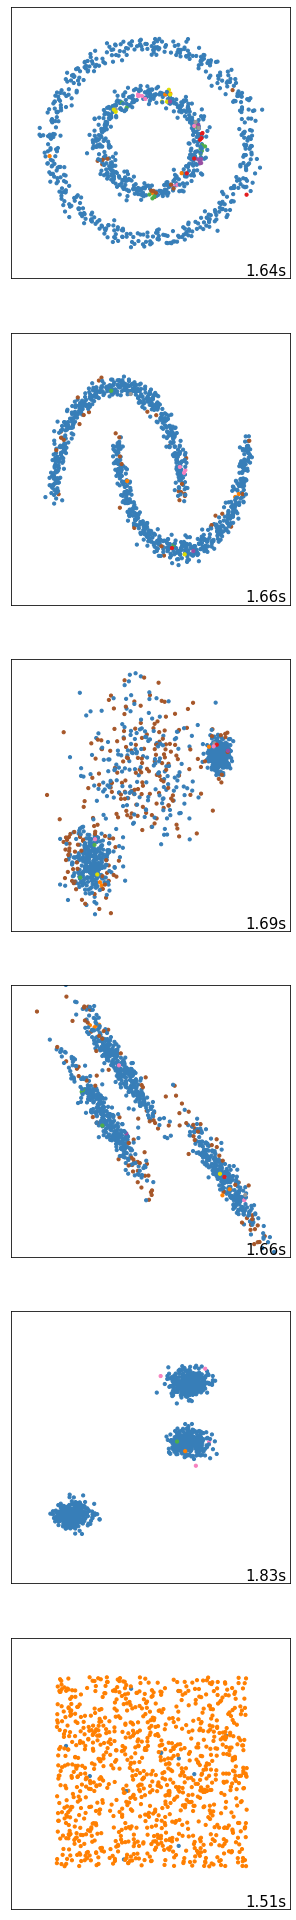

In [6]:
plt.figure(figsize=(5, 35))

plot_num = 1

for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    X = StandardScaler().fit_transform(X)
    t0 = time.time()
    y_pred = algorithm.fit_predict(X)
    t1 = time.time()
        
    plt.subplot(len(datasets), 1, plot_num)


    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()